In [1]:
# %% [markdown]
# # 数据序列化验证和修复工具
# 
# 本notebook实现了对7种常见数据序列化格式的解析验证、错误修复和宽松解析功能。
# 
# 支持的格式：
# - JSON
# - JSONC (JSON with Comments)
# - HJSON (Human JSON)
# - JSON5
# - XML
# - TOML
# - YAML

# %% [markdown]
# ## 1. 安装依赖包

# %%
# 安装必要的包（如果尚未安装）
import subprocess
import sys

def install_package(package):
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# 检查并安装必要的包
packages = ['pandas', 'pyyaml', 'toml', 'hjson', 'json5']
for package in packages:
    install_package(package)

# %% [markdown]
# ## 2. 导入必要的库

# %%
import json
import yaml
import toml
import hjson
import json5
import xml.etree.ElementTree as ET
import re
import pandas as pd
import numpy as np
from typing import Dict, Tuple, Any, Optional
import warnings
from datetime import datetime

# 设置pandas显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# %% [markdown]
# ## 3. 定义序列化验证器类

# %%
class SerializationValidator:
    """数据序列化验证和修复工具"""
    
    def __init__(self):
        # 初始化解析器
        self.parsers = {
            'json': self.parse_json,
            'jsonc': self.parse_jsonc,
            'hjson': self.parse_hjson,
            'json5': self.parse_json5,
            'xml': self.parse_xml,
            'toml': self.parse_toml,
            'yaml': self.parse_yaml
        }
        
        # 初始化修复器
        self.fixers = {
            'json': self.fix_json,
            'jsonc': self.fix_jsonc,
            'hjson': self.fix_hjson,
            'json5': self.fix_json5,
            'xml': self.fix_xml,
            'toml': self.fix_toml,
            'yaml': self.fix_yaml
        }
        
        # 初始化宽松解析器
        self.lenient_parsers = {
            'json': self.lenient_parse_json,
            'jsonc': self.lenient_parse_jsonc,
            'hjson': self.lenient_parse_hjson,
            'json5': self.lenient_parse_json5,
            'xml': self.lenient_parse_xml,
            'toml': self.lenient_parse_toml,
            'yaml': self.lenient_parse_yaml
        }
    
    # ========== 辅助函数 ==========
    
    def remove_jsonc_comments(self, jsonc_str: str) -> str:
        """移除JSONC中的注释"""
        # 移除单行注释 //
        jsonc_str = re.sub(r'//.*?$', '', jsonc_str, flags=re.MULTILINE)
        # 移除多行注释 /* */
        jsonc_str = re.sub(r'/\*.*?\*/', '', jsonc_str, flags=re.DOTALL)
        # 移除尾部逗号
        jsonc_str = re.sub(r',\s*([}\]])', r'\1', jsonc_str)
        return jsonc_str
    
    # ========== 严格解析器 ==========
    
    def parse_json(self, content: str) -> Tuple[bool, Any]:
        """解析JSON"""
        try:
            parsed = json.loads(content)
            return True, parsed
        except Exception as e:
            return False, str(e)
    
    def parse_jsonc(self, content: str) -> Tuple[bool, Any]:
        """解析JSONC（带注释的JSON）"""
        try:
            cleaned = self.remove_jsonc_comments(content)
            parsed = json.loads(cleaned)
            return True, parsed
        except Exception as e:
            return False, str(e)
    
    def parse_hjson(self, content: str) -> Tuple[bool, Any]:
        """解析HJSON"""
        try:
            parsed = hjson.loads(content)
            return True, parsed
        except Exception as e:
            return False, str(e)
    
    def parse_json5(self, content: str) -> Tuple[bool, Any]:
        """解析JSON5"""
        try:
            parsed = json5.loads(content)
            return True, parsed
        except Exception as e:
            return False, str(e)
    
    def parse_yaml(self, content: str) -> Tuple[bool, Any]:
        """解析YAML"""
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                parsed = yaml.safe_load(content)
            return True, parsed
        except Exception as e:
            return False, str(e)
    
    def parse_toml(self, content: str) -> Tuple[bool, Any]:
        """解析TOML"""
        try:
            parsed = toml.loads(content)
            return True, parsed
        except Exception as e:
            return False, str(e)
    
    def parse_xml(self, content: str) -> Tuple[bool, Any]:
        """解析XML"""
        try:
            root = ET.fromstring(content)
            return True, root
        except Exception as e:
            return False, str(e)
    
    # ========== 修复器 ==========
    
    def fix_json(self, content: str) -> str:
        """修复JSON中的简单语法错误"""
        fixed = content
        
        # 修复缺失的引号（键名）
        fixed = re.sub(r'([{,]\s*)(\w+)(\s*:)', r'\1"\2"\3', fixed)
        
        # 修复单引号为双引号
        fixed = re.sub(r"'([^']*)'", r'"\1"', fixed)
        
        # 修复尾部逗号
        fixed = re.sub(r',\s*}', '}', fixed)
        fixed = re.sub(r',\s*]', ']', fixed)
        
        # 修复缺失的逗号
        fixed = re.sub(r'}\s*"', '},"', fixed)
        fixed = re.sub(r']\s*"', '],"', fixed)
        fixed = re.sub(r'}\s*{', '},{', fixed)
        fixed = re.sub(r']\s*\[', '],[', fixed)
        fixed = re.sub(r'"\s*"', '","', fixed)
        
        # 修复布尔值和null
        fixed = re.sub(r'\bTrue\b', 'true', fixed)
        fixed = re.sub(r'\bFalse\b', 'false', fixed)
        fixed = re.sub(r'\bNone\b', 'null', fixed)
        
        return fixed
    
    def fix_jsonc(self, content: str) -> str:
        """修复JSONC中的简单语法错误"""
        # 先移除注释，然后应用JSON的修复
        cleaned = self.remove_jsonc_comments(content)
        return self.fix_json(cleaned)
    
    def fix_hjson(self, content: str) -> str:
        """修复HJSON中的简单语法错误"""
        fixed = content
        
        # HJSON相对宽松，主要修复一些明显的问题
        # 修复尾部逗号（HJSON允许，但确保格式正确）
        fixed = re.sub(r',\s*}', '}', fixed)
        fixed = re.sub(r',\s*]', ']', fixed)
        
        return fixed
    
    def fix_json5(self, content: str) -> str:
        """修复JSON5中的简单语法错误"""
        fixed = content
        
        # JSON5支持更多特性，但仍需要修复一些问题
        # 修复缺失的逗号
        fixed = re.sub(r'}\s*{', '},{', fixed)
        fixed = re.sub(r']\s*\[', '],[', fixed)
        
        # 修复引号问题（JSON5支持单引号，但要成对）
        # 计算单引号数量，如果是奇数，在末尾添加一个
        if fixed.count("'") % 2 == 1:
            fixed += "'"
        
        return fixed
    
    def fix_yaml(self, content: str) -> str:
        """修复YAML中的简单语法错误"""
        fixed = content
        
        # 修复缩进问题
        lines = fixed.split('\n')
        fixed_lines = []
        
        for line in lines:
            # 修复冒号后缺少空格
            line = re.sub(r':(\S)', r': \1', line)
            
            # 修复列表项
            line = re.sub(r'^(\s*)-(\S)', r'\1- \2', line)
            
            fixed_lines.append(line)
        
        fixed = '\n'.join(fixed_lines)
        
        return fixed
    
    def fix_toml(self, content: str) -> str:
        """修复TOML中的简单语法错误"""
        fixed = content
        
        # 修复表名缺失方括号
        fixed = re.sub(r'^(\w+)$', r'[\1]', fixed, flags=re.MULTILINE)
        
        # 修复字符串引号
        # TOML要求字符串必须用引号包围
        fixed = re.sub(r'=\s*([^"\'\[\]{},\n]+)$', r'= "\1"', fixed, flags=re.MULTILINE)
        
        # 修复布尔值
        fixed = re.sub(r'\bTrue\b', 'true', fixed)
        fixed = re.sub(r'\bFalse\b', 'false', fixed)
        
        return fixed
    
    def fix_xml(self, content: str) -> str:
        """修复XML中的简单语法错误"""
        fixed = content
        
        # 添加XML声明（如果缺失）
        if not fixed.strip().startswith('<?xml'):
            fixed = '<?xml version="1.0" encoding="UTF-8"?>\n' + fixed
        
        # 修复属性值缺少引号
        fixed = re.sub(r'(\w+)=([^"\s>]+)', r'\1="\2"', fixed)
        
        # 尝试修复未闭合的标签
        # 查找所有开始标签
        open_tags = re.findall(r'<(\w+)[^>]*(?<!/)>', fixed)
        # 查找所有结束标签
        close_tags = re.findall(r'</(\w+)>', fixed)
        
        # 统计标签数量
        tag_count = {}
        for tag in open_tags:
            tag_count[tag] = tag_count.get(tag, 0) + 1
        for tag in close_tags:
            tag_count[tag] = tag_count.get(tag, 0) - 1
        
        # 为未闭合的标签添加结束标签
        for tag, count in tag_count.items():
            if count > 0:
                fixed += f'</{tag}>' * count
        
        return fixed
    
    # ========== 宽松解析器 ==========
    
    def lenient_parse_json(self, content: str) -> Tuple[bool, Any]:
        """宽松的JSON解析"""
        # 尝试多种方法
        methods = [
            lambda: json.loads(self.fix_json(content)),
            lambda: eval(content.replace('true', 'True').replace('false', 'False').replace('null', 'None')),
            lambda: json.loads(re.search(r'[\{\[].*[\}\]]', content, re.DOTALL).group())
        ]
        
        for method in methods:
            try:
                result = method()
                return True, result
            except:
                continue
        
        return False, None
    
    def lenient_parse_jsonc(self, content: str) -> Tuple[bool, Any]:
        """宽松的JSONC解析"""
        cleaned = self.remove_jsonc_comments(content)
        return self.lenient_parse_json(cleaned)
    
    def lenient_parse_hjson(self, content: str) -> Tuple[bool, Any]:
        """宽松的HJSON解析"""
        try:
            # HJSON本身就很宽松，尝试修复后解析
            fixed = self.fix_hjson(content)
            parsed = hjson.loads(fixed)
            return True, parsed
        except:
            # 尝试作为JSON解析
            return self.lenient_parse_json(content)
    
    def lenient_parse_json5(self, content: str) -> Tuple[bool, Any]:
        """宽松的JSON5解析"""
        try:
            # 尝试修复后解析
            fixed = self.fix_json5(content)
            parsed = json5.loads(fixed)
            return True, parsed
        except:
            # 尝试作为JSON解析
            return self.lenient_parse_json(content)
    
    def lenient_parse_yaml(self, content: str) -> Tuple[bool, Any]:
        """宽松的YAML解析"""
        try:
            # 使用更宽松的loader
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                parsed = yaml.load(content, Loader=yaml.FullLoader)
            return True, parsed
        except:
            # 尝试简单的键值对解析
            try:
                lines = content.strip().split('\n')
                result = {}
                for line in lines:
                    if ':' in line and not line.strip().startswith('#'):
                        key, value = line.split(':', 1)
                        result[key.strip()] = value.strip()
                if result:
                    return True, result
            except:
                pass
        
        return False, None
    
    def lenient_parse_toml(self, content: str) -> Tuple[bool, Any]:
        """宽松的TOML解析"""
        try:
            # 尝试修复后解析
            fixed = self.fix_toml(content)
            parsed = toml.loads(fixed)
            return True, parsed
        except:
            # 尝试提取有效的TOML片段
            try:
                lines = content.strip().split('\n')
                valid_lines = []
                for line in lines:
                    if '=' in line or line.strip().startswith('['):
                        valid_lines.append(line)
                if valid_lines:
                    parsed = toml.loads('\n'.join(valid_lines))
                    return True, parsed
            except:
                pass
        
        return False, None
    
    def lenient_parse_xml(self, content: str) -> Tuple[bool, Any]:
        """宽松的XML解析"""
        try:
            # 尝试修复后解析
            fixed = self.fix_xml(content)
            root = ET.fromstring(fixed)
            return True, root
        except:
            # 尝试提取XML片段
            try:
                match = re.search(r'<[^>]+>.*</[^>]+>', content, re.DOTALL)
                if match:
                    fragment = match.group()
                    if not fragment.strip().startswith('<?xml'):
                        fragment = '<?xml version="1.0" encoding="UTF-8"?>\n<root>\n' + fragment + '\n</root>'
                    root = ET.fromstring(fragment)
                    return True, root
            except:
                pass
        
        return False, None

# %% [markdown]
# ## 4. 定义数据处理函数

# %%
def process_dataframe(validator: SerializationValidator, df: pd.DataFrame) -> pd.DataFrame:
    """处理数据框，进行解析验证和修复"""
    # 复制数据框
    result_df = df.copy()
    
    # 初始化结果列
    result_df['parse_success_strict'] = False
    result_df['parse_error'] = ''
    result_df['fixed_input'] = result_df['user_input']
    result_df['parse_success_after_fix'] = False
    result_df['parse_success_lenient'] = False
    
    print("开始处理数据...")
    print(f"总记录数: {len(df)}")
    
    # 第一阶段：严格解析
    print("\n第一阶段：严格解析")
    for idx, row in result_df.iterrows():
        format_type = row['format'].lower()
        user_input = row['user_input']
        
        if format_type in validator.parsers:
            success, result = validator.parsers[format_type](user_input)
            result_df.at[idx, 'parse_success_strict'] = success
            if not success:
                result_df.at[idx, 'parse_error'] = str(result)
    
    strict_success = result_df['parse_success_strict'].sum()
    print(f"严格解析成功: {strict_success}/{len(df)} ({strict_success/len(df)*100:.2f}%)")
    
    # 第二阶段：修复并重新解析
    print("\n第二阶段：错误修复")
    failed_first = result_df[~result_df['parse_success_strict']]
    print(f"需要修复的记录数: {len(failed_first)}")
    
    for idx, row in result_df.iterrows():
        if not row['parse_success_strict']:
            format_type = row['format'].lower()
            user_input = row['user_input']
            
            if format_type in validator.fixers:
                # 应用修复
                fixed_input = validator.fixers[format_type](user_input)
                result_df.at[idx, 'fixed_input'] = fixed_input
                
                # 再次尝试解析
                success, _ = validator.parsers[format_type](fixed_input)
                result_df.at[idx, 'parse_success_after_fix'] = success
        else:
            # 如果第一次就成功了，第二次也标记为成功
            result_df.at[idx, 'parse_success_after_fix'] = True
    
    fix_success = result_df['parse_success_after_fix'].sum()
    print(f"修复后解析成功: {fix_success}/{len(df)} ({fix_success/len(df)*100:.2f}%)")
    
    # 第三阶段：宽松解析
    print("\n第三阶段：宽松解析")
    failed_second = result_df[~result_df['parse_success_after_fix']]
    print(f"需要宽松解析的记录数: {len(failed_second)}")
    
    for idx, row in result_df.iterrows():
        if not row['parse_success_after_fix']:
            format_type = row['format'].lower()
            fixed_input = row['fixed_input']
            
            if format_type in validator.lenient_parsers:
                success, _ = validator.lenient_parsers[format_type](fixed_input)
                result_df.at[idx, 'parse_success_lenient'] = success
    
    # 对于前两阶段成功的，宽松解析也标记为成功
    result_df.loc[result_df['parse_success_after_fix'] == True, 'parse_success_lenient'] = True
    
    lenient_success = result_df['parse_success_lenient'].sum()
    print(f"宽松解析成功: {lenient_success}/{len(df)} ({lenient_success/len(df)*100:.2f}%)")
    
    return result_df

# %% [markdown]
# ## 5. 生成详细报告

# %%
def generate_report(df: pd.DataFrame) -> Dict[str, Any]:
    """生成解析报告"""
    total_count = len(df)
    
    report = {
        'summary': {
            'total_records': total_count,
            'strict_parse': {
                'success': int(df['parse_success_strict'].sum()),
                'failed': int((~df['parse_success_strict']).sum()),
                'rate': float(df['parse_success_strict'].mean() * 100)
            },
            'after_fix': {
                'success': int(df['parse_success_after_fix'].sum()),
                'failed': int((~df['parse_success_after_fix']).sum()),
                'rate': float(df['parse_success_after_fix'].mean() * 100)
            },
            'lenient_parse': {
                'success': int(df['parse_success_lenient'].sum()),
                'failed': int((~df['parse_success_lenient']).sum()),
                'rate': float(df['parse_success_lenient'].mean() * 100)
            }
        },
        'by_format': {}
    }
    
    # 按格式分组统计
    for format_type in df['format'].unique():
        format_df = df[df['format'] == format_type]
        report['by_format'][format_type] = {
            'count': len(format_df),
            'strict_success': int(format_df['parse_success_strict'].sum()),
            'strict_rate': float(format_df['parse_success_strict'].mean() * 100),
            'after_fix_success': int(format_df['parse_success_after_fix'].sum()),
            'after_fix_rate': float(format_df['parse_success_after_fix'].mean() * 100),
            'lenient_success': int(format_df['parse_success_lenient'].sum()),
            'lenient_rate': float(format_df['parse_success_lenient'].mean() * 100)
        }
    
    return report

# %% [markdown]
# ## 6. 可视化函数

# %%
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_results(df: pd.DataFrame, report: Dict[str, Any]):
    """可视化解析结果"""
    # 设置样式
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")
    
    # 创建图形
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. 总体成功率对比
    ax1 = axes[0, 0]
    stages = ['Strict Parse', 'After Fix', 'Lenient Parse']
    success_rates = [
        report['summary']['strict_parse']['rate'],
        report['summary']['after_fix']['rate'],
        report['summary']['lenient_parse']['rate']
    ]
    
    bars = ax1.bar(stages, success_rates)
    ax1.set_ylabel('Success Rate (%)')
    ax1.set_title('Overall Parsing Success Rates by Stage')
    ax1.set_ylim(0, 105)
    
    # 添加数值标签
    for bar, rate in zip(bars, success_rates):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{rate:.1f}%', ha='center', va='bottom')
    
    # 2. 按格式类型的成功率
    ax2 = axes[0, 1]
    formats = list(report['by_format'].keys())
    strict_rates = [report['by_format'][f]['strict_rate'] for f in formats]
    fix_rates = [report['by_format'][f]['after_fix_rate'] for f in formats]
    lenient_rates = [report['by_format'][f]['lenient_rate'] for f in formats]
    
    x = np.arange(len(formats))
    width = 0.25
    
    ax2.bar(x - width, strict_rates, width, label='Strict')
    ax2.bar(x, fix_rates, width, label='After Fix')
    ax2.bar(x + width, lenient_rates, width, label='Lenient')
    
    ax2.set_xlabel('Format')
    ax2.set_ylabel('Success Rate (%)')
    ax2.set_title('Success Rates by Format Type')
    ax2.set_xticks(x)
    ax2.set_xticklabels(formats, rotation=45)
    ax2.legend()
    ax2.set_ylim(0, 105)
    
    # 3. 改进效果（提升的成功数）
    ax3 = axes[1, 0]
    improvements = []
    labels = []
    
    for format_type in formats:
        format_data = report['by_format'][format_type]
        strict = format_data['strict_success']
        after_fix = format_data['after_fix_success']
        lenient = format_data['lenient_success']
        
        fix_improvement = after_fix - strict
        lenient_improvement = lenient - after_fix
        
        improvements.append([fix_improvement, lenient_improvement])
        labels.append(format_type)
    
    improvements = np.array(improvements).T
    
    x = np.arange(len(labels))
    ax3.bar(x, improvements[0], label='Fixed by repair', color='lightgreen')
    ax3.bar(x, improvements[1], bottom=improvements[0], label='Fixed by lenient parsing', color='lightblue')
    
    ax3.set_xlabel('Format')
    ax3.set_ylabel('Number of Records')
    ax3.set_title('Improvement by Stage and Format')
    ax3.set_xticks(x)
    ax3.set_xticklabels(labels, rotation=45)
    ax3.legend()
    
    # 4. 失败记录分析
    ax4 = axes[1, 1]
    final_failures = df[~df['parse_success_lenient']]
    if len(final_failures) > 0:
        failure_counts = final_failures['format'].value_counts()
        ax4.pie(failure_counts.values, labels=failure_counts.index, autopct='%1.1f%%')
        ax4.set_title(f'Distribution of Final Failures (n={len(final_failures)})')
    else:
        ax4.text(0.5, 0.5, 'No failures after lenient parsing!', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=16)
        ax4.set_title('Final Failures')
        ax4.axis('off')
    
    plt.tight_layout()
    plt.show()

# %% [markdown]
# ## 7. 创建示例数据并测试

# %%
# 创建包含所有7种格式的示例数据
sample_data = pd.DataFrame({
    'id': range(1, 22),
    'format': ['json'] * 3 + ['jsonc'] * 3 + ['hjson'] * 3 + ['json5'] * 3 + 
              ['xml'] * 3 + ['toml'] * 3 + ['yaml'] * 3,
    'user_input': [
        # JSON examples
        '{"name": "test", "value": 123}',  # 正确
        '{name: "test", value: 123,}',     # 错误：缺少引号，尾部逗号
        '{"data": [1,2,3}',                 # 错误：缺少闭合括号
        
        # JSONC examples
        '{"name": "test", /* comment */ "value": 123}',  # 正确
        '{name: "test", // comment\n value: 123,}',      # 错误
        '{"a": 1, "b": 2 /* missing comma */ "c": 3}',   # 错误：缺少逗号
        
        # HJSON examples
        '{name: test, value: 123}',        # 正确（HJSON允许）
        '{name: test value: 123}',         # 错误：缺少逗号
        'name: test\nvalue: 123',          # 正确（HJSON格式）
        
        # JSON5 examples
        "{name: 'test', value: 123}",      # 正确（JSON5允许）
        '{name: "test", value: 123,}',     # 正确（JSON5允许尾部逗号）
        "{name: 'test' value: 123}",       # 错误：缺少逗号
        
        # XML examples
        '<root><name>test</name><value>123</value></root>',  # 正确
        '<root><name>test</name><value>123</root>',          # 错误：未闭合
        '<root name=test>value</root>',                      # 错误：属性缺少引号
        
        # TOML examples
        'name = "test"\nvalue = 123',      # 正确
        'name = test\nvalue = 123',        # 错误：字符串缺少引号
        '[section]\nname = "test"',        # 正确
        
        # YAML examples
        'name: test\nvalue: 123',          # 正确
        'name:test\n  value:123',          # 错误：冒号后缺少空格
        '- item1\n-item2\n- item3',        # 错误：列表项格式
    ]
})

print("示例数据集信息：")
print(f"总记录数: {len(sample_data)}")

Installing pyyaml...


Error processing line 1 of /opt/anaconda3/lib/python3.8/site-packages/prose-datainsights-nspkg.pth:

  Traceback (most recent call last):
    File "/opt/anaconda3/lib/python3.8/site.py", line 169, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 553, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored


示例数据集信息：
总记录数: 21


In [25]:
# %% [markdown]
# # 数据序列化验证和修复工具
# 
# 本notebook实现了对7种常见数据序列化格式的解析验证、错误修复和宽松解析功能。
# 
# 支持的格式：
# - JSON
# - JSONC (JSON with Comments)
# - HJSON (Human JSON)
# - JSON5
# - XML
# - TOML
# - YAML

# %% [markdown]
# ## 1. 安装依赖包

# %%
# 安装必要的包（如果尚未安装）
import subprocess
import sys

def install_package(package):
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# 检查并安装必要的包
packages = ['pandas', 'pyyaml', 'toml', 'hjson', 'json5']
for package in packages:
    install_package(package)

# %% [markdown]
# ## 2. 导入必要的库

# %%
import json
import yaml
import toml
import hjson
import json5
import xml.etree.ElementTree as ET
import re
import pandas as pd
import numpy as np
from typing import Dict, Tuple, Any, Optional
import warnings
from datetime import datetime

# 设置pandas显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# %% [markdown]
# ## 3. 定义序列化验证器类

# %%
class SerializationValidator:
    """数据序列化验证和修复工具"""
    
    def __init__(self):
        # 初始化解析器
        self.parsers = {
            'json': self.parse_json,
            'jsonc': self.parse_jsonc,
            'hjson': self.parse_hjson,
            'json5': self.parse_json5,
            'xml': self.parse_xml,
            'toml': self.parse_toml,
            'yaml': self.parse_yaml
        }
        
        # 初始化修复器
        self.fixers = {
            'json': self.fix_json,
            'jsonc': self.fix_jsonc,
            'hjson': self.fix_hjson,
            'json5': self.fix_json5,
            'xml': self.fix_xml,
            'toml': self.fix_toml,
            'yaml': self.fix_yaml
        }
        
        # 初始化宽松解析器
        self.lenient_parsers = {
            'json': self.lenient_parse_json,
            'jsonc': self.lenient_parse_jsonc,
            'hjson': self.lenient_parse_hjson,
            'json5': self.lenient_parse_json5,
            'xml': self.lenient_parse_xml,
            'toml': self.lenient_parse_toml,
            'yaml': self.lenient_parse_yaml
        }
    
    # ========== 辅助函数 ==========
    
    def remove_jsonc_comments(self, jsonc_str: str) -> str:
        """移除JSONC中的注释"""
        # 保护字符串中的内容
        strings = []
        def protect_string(match):
            strings.append(match.group(0))
            return f'__STRING_{len(strings)-1}__'
        
        # 临时替换字符串内容
        protected = re.sub(r'"[^"]*"', protect_string, jsonc_str)
        
        # 移除单行注释 //
        protected = re.sub(r'//.*?
    
    # ========== 严格解析器 ==========
    
    def parse_json(self, content: str) -> Tuple[bool, Any]:
        """解析JSON"""
        try:
            parsed = json.loads(content)
            return True, parsed
        except Exception as e:
            return False, str(e)
    
    def parse_jsonc(self, content: str) -> Tuple[bool, Any]:
        """解析JSONC（带注释的JSON）"""
        try:
            cleaned = self.remove_jsonc_comments(content)
            parsed = json.loads(cleaned)
            return True, parsed
        except Exception as e:
            return False, str(e)
    
    def parse_hjson(self, content: str) -> Tuple[bool, Any]:
        """解析HJSON"""
        try:
            parsed = hjson.loads(content)
            return True, parsed
        except Exception as e:
            return False, str(e)
    
    def parse_json5(self, content: str) -> Tuple[bool, Any]:
        """解析JSON5"""
        try:
            parsed = json5.loads(content)
            return True, parsed
        except Exception as e:
            return False, str(e)
    
    def parse_yaml(self, content: str) -> Tuple[bool, Any]:
        """解析YAML"""
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                parsed = yaml.safe_load(content)
            return True, parsed
        except Exception as e:
            return False, str(e)
    
    def parse_toml(self, content: str) -> Tuple[bool, Any]:
        """解析TOML"""
        try:
            parsed = toml.loads(content)
            return True, parsed
        except Exception as e:
            return False, str(e)
    
    def parse_xml(self, content: str) -> Tuple[bool, Any]:
        """解析XML"""
        try:
            # 确保内容被trim
            content = content.strip()
            # 如果没有XML声明，添加一个
            if not content.startswith('<?xml'):
                # 检查是否有根元素
                if not content.startswith('<'):
                    return False, "Invalid XML: no root element"
                # 尝试直接解析
            root = ET.fromstring(content)
            return True, root
        except Exception as e:
            return False, str(e)
    
    # ========== 修复器 ==========
    
    def fix_json(self, content: str) -> str:
        """修复JSON中的简单语法错误"""
        fixed = content
        
        # 修复缺失的引号（键名）
        fixed = re.sub(r'([{,]\s*)(\w+)(\s*:)', r'\1"\2"\3', fixed)
        
        # 修复单引号为双引号
        fixed = re.sub(r"'([^']*)'", r'"\1"', fixed)
        
        # 修复尾部逗号
        fixed = re.sub(r',\s*}', '}', fixed)
        fixed = re.sub(r',\s*]', ']', fixed)
        
        # 修复缺失的逗号
        fixed = re.sub(r'}\s*"', '},"', fixed)
        fixed = re.sub(r']\s*"', '],"', fixed)
        fixed = re.sub(r'}\s*{', '},{', fixed)
        fixed = re.sub(r']\s*\[', '],[', fixed)
        fixed = re.sub(r'"\s*"', '","', fixed)
        
        # 修复布尔值和null
        fixed = re.sub(r'\bTrue\b', 'true', fixed)
        fixed = re.sub(r'\bFalse\b', 'false', fixed)
        fixed = re.sub(r'\bNone\b', 'null', fixed)
        
        return fixed
    
    def fix_jsonc(self, content: str) -> str:
        """修复JSONC中的简单语法错误"""
        # 先保留注释的位置
        # 移除注释但保留结构
        cleaned = self.remove_jsonc_comments(content)
        
        # 应用JSON的修复到清理后的内容
        fixed = self.fix_json(cleaned)
        
        return fixed
    
    def fix_hjson(self, content: str) -> str:
        """修复HJSON中的简单语法错误"""
        fixed = content
        
        # HJSON相对宽松，主要修复一些明显的问题
        # 修复尾部逗号（HJSON允许，但确保格式正确）
        fixed = re.sub(r',\s*}', '}', fixed)
        fixed = re.sub(r',\s*]', ']', fixed)
        
        return fixed
    
    def fix_json5(self, content: str) -> str:
        """修复JSON5中的简单语法错误"""
        fixed = content
        
        # JSON5支持更多特性，但仍需要修复一些问题
        # 修复缺失的逗号
        fixed = re.sub(r'}\s*{', '},{', fixed)
        fixed = re.sub(r']\s*\[', '],[', fixed)
        
        # 修复引号问题（JSON5支持单引号，但要成对）
        # 计算单引号数量，如果是奇数，在末尾添加一个
        if fixed.count("'") % 2 == 1:
            fixed += "'"
        
        return fixed
    
    def fix_yaml(self, content: str) -> str:
        """修复YAML中的简单语法错误"""
        fixed = content
        
        # 修复缩进问题
        lines = fixed.split('\n')
        fixed_lines = []
        
        for line in lines:
            # 修复冒号后缺少空格
            line = re.sub(r':(\S)', r': \1', line)
            
            # 修复列表项
            line = re.sub(r'^(\s*)-(\S)', r'\1- \2', line)
            
            fixed_lines.append(line)
        
        fixed = '\n'.join(fixed_lines)
        
        return fixed
    
    def fix_toml(self, content: str) -> str:
        """修复TOML中的简单语法错误"""
        fixed = content
        
        # 修复表名缺失方括号
        fixed = re.sub(r'^(\w+)$', r'[\1]', fixed, flags=re.MULTILINE)
        
        # 修复字符串引号
        # TOML要求字符串必须用引号包围
        fixed = re.sub(r'=\s*([^"\'\[\]{},\n]+)$', r'= "\1"', fixed, flags=re.MULTILINE)
        
        # 修复布尔值
        fixed = re.sub(r'\bTrue\b', 'true', fixed)
        fixed = re.sub(r'\bFalse\b', 'false', fixed)
        
        return fixed
    
    def fix_xml(self, content: str) -> str:
        """修复XML中的简单语法错误"""
        fixed = content
        
        # 添加XML声明（如果缺失）
        if not fixed.strip().startswith('<?xml'):
            fixed = '<?xml version="1.0" encoding="UTF-8"?>\n' + fixed
        
        # 修复属性值缺少引号
        fixed = re.sub(r'(\w+)=([^"\s>]+)', r'\1="\2"', fixed)
        
        # 尝试修复未闭合的标签
        # 查找所有开始标签
        open_tags = re.findall(r'<(\w+)[^>]*(?<!/)>', fixed)
        # 查找所有结束标签
        close_tags = re.findall(r'</(\w+)>', fixed)
        
        # 统计标签数量
        tag_count = {}
        for tag in open_tags:
            tag_count[tag] = tag_count.get(tag, 0) + 1
        for tag in close_tags:
            tag_count[tag] = tag_count.get(tag, 0) - 1
        
        # 为未闭合的标签添加结束标签
        for tag, count in tag_count.items():
            if count > 0:
                fixed += f'</{tag}>' * count
        
        return fixed
    
    # ========== 宽松解析器 ==========
    
    def lenient_parse_json(self, content: str) -> Tuple[bool, Any]:
        """宽松的JSON解析"""
        # 尝试多种方法
        methods = [
            lambda: json.loads(self.fix_json(content)),
            lambda: eval(content.replace('true', 'True').replace('false', 'False').replace('null', 'None')),
            lambda: json.loads(re.search(r'[\{\[].*[\}\]]', content, re.DOTALL).group())
        ]
        
        for method in methods:
            try:
                result = method()
                return True, result
            except:
                continue
        
        return False, None
    
    def lenient_parse_jsonc(self, content: str) -> Tuple[bool, Any]:
        """宽松的JSONC解析"""
        cleaned = self.remove_jsonc_comments(content)
        return self.lenient_parse_json(cleaned)
    
    def lenient_parse_hjson(self, content: str) -> Tuple[bool, Any]:
        """宽松的HJSON解析"""
        try:
            # HJSON本身就很宽松，尝试修复后解析
            fixed = self.fix_hjson(content)
            parsed = hjson.loads(fixed)
            return True, parsed
        except:
            # 尝试作为JSON解析
            return self.lenient_parse_json(content)
    
    def lenient_parse_json5(self, content: str) -> Tuple[bool, Any]:
        """宽松的JSON5解析"""
        try:
            # 尝试修复后解析
            fixed = self.fix_json5(content)
            parsed = json5.loads(fixed)
            return True, parsed
        except:
            # 尝试作为JSON解析
            return self.lenient_parse_json(content)
    
    def lenient_parse_yaml(self, content: str) -> Tuple[bool, Any]:
        """宽松的YAML解析"""
        try:
            # 使用更宽松的loader
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                parsed = yaml.load(content, Loader=yaml.FullLoader)
            return True, parsed
        except:
            # 尝试简单的键值对解析
            try:
                lines = content.strip().split('\n')
                result = {}
                for line in lines:
                    if ':' in line and not line.strip().startswith('#'):
                        key, value = line.split(':', 1)
                        result[key.strip()] = value.strip()
                if result:
                    return True, result
            except:
                pass
        
        return False, None
    
    def lenient_parse_toml(self, content: str) -> Tuple[bool, Any]:
        """宽松的TOML解析"""
        try:
            # 尝试修复后解析
            fixed = self.fix_toml(content)
            parsed = toml.loads(fixed)
            return True, parsed
        except:
            # 尝试提取有效的TOML片段
            try:
                lines = content.strip().split('\n')
                valid_lines = []
                for line in lines:
                    if '=' in line or line.strip().startswith('['):
                        valid_lines.append(line)
                if valid_lines:
                    parsed = toml.loads('\n'.join(valid_lines))
                    return True, parsed
            except:
                pass
        
        return False, None
    
    def lenient_parse_xml(self, content: str) -> Tuple[bool, Any]:
        """宽松的XML解析"""
        try:
            # 尝试修复后解析
            fixed = self.fix_xml(content)
            root = ET.fromstring(fixed)
            return True, root
        except:
            # 尝试提取XML片段
            try:
                match = re.search(r'<[^>]+>.*</[^>]+>', content, re.DOTALL)
                if match:
                    fragment = match.group()
                    if not fragment.strip().startswith('<?xml'):
                        fragment = '<?xml version="1.0" encoding="UTF-8"?>\n<root>\n' + fragment + '\n</root>'
                    root = ET.fromstring(fragment)
                    return True, root
            except:
                pass
        
        return False, None

# %% [markdown]
# ## 4. 定义数据处理函数

# %%
def process_dataframe(validator: SerializationValidator, df: pd.DataFrame) -> pd.DataFrame:
    """处理数据框，进行解析验证和修复"""
    # 复制数据框
    result_df = df.copy()
    
    # 初始化结果列
    result_df['parse_success_strict'] = False
    result_df['parse_error'] = ''
    result_df['fixed_input'] = result_df['user_input']
    result_df['parse_success_after_fix'] = False
    result_df['parse_success_lenient'] = False
    
    print("开始处理数据...")
    print(f"总记录数: {len(df)}")
    
    # 第一阶段：严格解析
    print("\n第一阶段：严格解析")
    for idx, row in result_df.iterrows():
        format_type = row['format'].lower()
        user_input = row['user_input']
        
        if format_type in validator.parsers:
            success, result = validator.parsers[format_type](user_input)
            result_df.at[idx, 'parse_success_strict'] = success
            if not success:
                result_df.at[idx, 'parse_error'] = str(result)
    
    strict_success = result_df['parse_success_strict'].sum()
    print(f"严格解析成功: {strict_success}/{len(df)} ({strict_success/len(df)*100:.2f}%)")
    
    # 第二阶段：修复并重新解析
    print("\n第二阶段：错误修复")
    failed_first = result_df[~result_df['parse_success_strict']]
    print(f"需要修复的记录数: {len(failed_first)}")
    
    for idx, row in result_df.iterrows():
        if not row['parse_success_strict']:
            format_type = row['format'].lower()
            user_input = row['user_input']
            
            if format_type in validator.fixers:
                # 应用修复
                fixed_input = validator.fixers[format_type](user_input)
                result_df.at[idx, 'fixed_input'] = fixed_input
                
                # 再次尝试解析
                success, _ = validator.parsers[format_type](fixed_input)
                result_df.at[idx, 'parse_success_after_fix'] = success
        else:
            # 如果第一次就成功了，第二次也标记为成功
            result_df.at[idx, 'parse_success_after_fix'] = True
    
    fix_success = result_df['parse_success_after_fix'].sum()
    print(f"修复后解析成功: {fix_success}/{len(df)} ({fix_success/len(df)*100:.2f}%)")
    
    # 第三阶段：宽松解析
    print("\n第三阶段：宽松解析")
    failed_second = result_df[~result_df['parse_success_after_fix']]
    print(f"需要宽松解析的记录数: {len(failed_second)}")
    
    for idx, row in result_df.iterrows():
        if not row['parse_success_after_fix']:
            format_type = row['format'].lower()
            fixed_input = row['fixed_input']
            
            if format_type in validator.lenient_parsers:
                success, _ = validator.lenient_parsers[format_type](fixed_input)
                result_df.at[idx, 'parse_success_lenient'] = success
    
    # 对于前两阶段成功的，宽松解析也标记为成功
    result_df.loc[result_df['parse_success_after_fix'] == True, 'parse_success_lenient'] = True
    
    lenient_success = result_df['parse_success_lenient'].sum()
    print(f"宽松解析成功: {lenient_success}/{len(df)} ({lenient_success/len(df)*100:.2f}%)")
    
    return result_df

# %% [markdown]
# ## 5. 生成详细报告

# %%
def generate_report(df: pd.DataFrame) -> Dict[str, Any]:
    """生成解析报告"""
    total_count = len(df)
    
    report = {
        'summary': {
            'total_records': total_count,
            'strict_parse': {
                'success': int(df['parse_success_strict'].sum()),
                'failed': int((~df['parse_success_strict']).sum()),
                'rate': float(df['parse_success_strict'].mean() * 100)
            },
            'after_fix': {
                'success': int(df['parse_success_after_fix'].sum()),
                'failed': int((~df['parse_success_after_fix']).sum()),
                'rate': float(df['parse_success_after_fix'].mean() * 100)
            },
            'lenient_parse': {
                'success': int(df['parse_success_lenient'].sum()),
                'failed': int((~df['parse_success_lenient']).sum()),
                'rate': float(df['parse_success_lenient'].mean() * 100)
            }
        },
        'by_format': {}
    }
    
    # 按格式分组统计
    for format_type in df['format'].unique():
        format_df = df[df['format'] == format_type]
        report['by_format'][format_type] = {
            'count': len(format_df),
            'strict_success': int(format_df['parse_success_strict'].sum()),
            'strict_rate': float(format_df['parse_success_strict'].mean() * 100),
            'after_fix_success': int(format_df['parse_success_after_fix'].sum()),
            'after_fix_rate': float(format_df['parse_success_after_fix'].mean() * 100),
            'lenient_success': int(format_df['parse_success_lenient'].sum()),
            'lenient_rate': float(format_df['parse_success_lenient'].mean() * 100)
        }
    
    return report

# %% [markdown]
# ## 6. 可视化函数

# %%
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_results(df: pd.DataFrame, report: Dict[str, Any]):
    """可视化解析结果"""
    # 设置样式
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")
    
    # 创建图形
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. 总体成功率对比
    ax1 = axes[0, 0]
    stages = ['Strict Parse', 'After Fix', 'Lenient Parse']
    success_rates = [
        report['summary']['strict_parse']['rate'],
        report['summary']['after_fix']['rate'],
        report['summary']['lenient_parse']['rate']
    ]
    
    bars = ax1.bar(stages, success_rates)
    ax1.set_ylabel('Success Rate (%)')
    ax1.set_title('Overall Parsing Success Rates by Stage')
    ax1.set_ylim(0, 105)
    
    # 添加数值标签
    for bar, rate in zip(bars, success_rates):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{rate:.1f}%', ha='center', va='bottom')
    
    # 2. 按格式类型的成功率
    ax2 = axes[0, 1]
    formats = list(report['by_format'].keys())
    strict_rates = [report['by_format'][f]['strict_rate'] for f in formats]
    fix_rates = [report['by_format'][f]['after_fix_rate'] for f in formats]
    lenient_rates = [report['by_format'][f]['lenient_rate'] for f in formats]
    
    x = np.arange(len(formats))
    width = 0.25
    
    ax2.bar(x - width, strict_rates, width, label='Strict')
    ax2.bar(x, fix_rates, width, label='After Fix')
    ax2.bar(x + width, lenient_rates, width, label='Lenient')
    
    ax2.set_xlabel('Format')
    ax2.set_ylabel('Success Rate (%)')
    ax2.set_title('Success Rates by Format Type')
    ax2.set_xticks(x)
    ax2.set_xticklabels(formats, rotation=45)
    ax2.legend()
    ax2.set_ylim(0, 105)
    
    # 3. 改进效果（提升的成功数）
    ax3 = axes[1, 0]
    improvements = []
    labels = []
    
    for format_type in formats:
        format_data = report['by_format'][format_type]
        strict = format_data['strict_success']
        after_fix = format_data['after_fix_success']
        lenient = format_data['lenient_success']
        
        fix_improvement = after_fix - strict
        lenient_improvement = lenient - after_fix
        
        improvements.append([fix_improvement, lenient_improvement])
        labels.append(format_type)
    
    improvements = np.array(improvements).T
    
    x = np.arange(len(labels))
    ax3.bar(x, improvements[0], label='Fixed by repair', color='lightgreen')
    ax3.bar(x, improvements[1], bottom=improvements[0], label='Fixed by lenient parsing', color='lightblue')
    
    ax3.set_xlabel('Format')
    ax3.set_ylabel('Number of Records')
    ax3.set_title('Improvement by Stage and Format')
    ax3.set_xticks(x)
    ax3.set_xticklabels(labels, rotation=45)
    ax3.legend()
    
    # 4. 失败记录分析
    ax4 = axes[1, 1]
    final_failures = df[~df['parse_success_lenient']]
    if len(final_failures) > 0:
        failure_counts = final_failures['format'].value_counts()
        ax4.pie(failure_counts.values, labels=failure_counts.index, autopct='%1.1f%%')
        ax4.set_title(f'Distribution of Final Failures (n={len(final_failures)})')
    else:
        ax4.text(0.5, 0.5, 'No failures after lenient parsing!', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=16)
        ax4.set_title('Final Failures')
        ax4.axis('off')
    
    plt.tight_layout()
    plt.show()

# %% [markdown]
# ## 7. 创建示例数据并测试

# %%
# 创建包含所有7种格式的示例数据
sample_data = pd.DataFrame({
    'id': range(1, 22),
    'format': ['json'] * 3 + ['jsonc'] * 3 + ['hjson'] * 3 + ['json5'] * 3 + 
              ['xml'] * 3 + ['toml'] * 3 + ['yaml'] * 3,
    'user_input': [
        # JSON examples
        '{"name": "test", "value": 123}',  # 正确
        '{name: "test", value: 123,}',     # 错误：缺少引号，尾部逗号
        '{"data": [1,2,3}',                 # 错误：缺少闭合括号
        
        # JSONC examples
        '{"name": "test", /* comment */ "value": 123}',  # 正确
        '{name: "test", // comment\n value: 123,}',      # 错误
        '{"a": 1, "b": 2 /* missing comma */ "c": 3}',   # 错误：缺少逗号
        
        # HJSON examples
        '{name: test, value: 123}',        # 正确（HJSON允许无引号）
        '{name: test value: 123}',         # 错误：缺少逗号
        '{\n  name: test\n  value: 123\n}',# 正确（HJSON格式，多行）
        
        # JSON5 examples
        "{name: 'test', value: 123}",      # 正确（JSON5允许）
        '{name: "test", value: 123,}',     # 正确（JSON5允许尾部逗号）
        "{name: 'test' value: 123}",       # 错误：缺少逗号
        
        # XML examples
        '<root><name>test</name><value>123</value></root>',  # 正确
        '<root><name>test</name><value>123</root>',          # 错误：未闭合
        '<root name=test>value</root>',                      # 错误：属性缺少引号
        
        # TOML examples
        'name = "test"\nvalue = 123',      # 正确
        'name = test\nvalue = 123',        # 错误：字符串缺少引号
        '[section]\nname = "test"',        # 正确
        
        # YAML examples
        'name: test\nvalue: 123',          # 正确
        'name:test\n  value:123',          # 错误：冒号后缺少空格
        '- item1\n-item2\n- item3',        # 错误：列表项格式
    ]
})

print("示例数据集信息：")
print(f"总记录数: {len(sample_data)}")
print(f"格式分布: {sample_data['format'].value_counts().to_dict()}")

# %% [markdown]
# ## 8. 运行验证流程

# %%
# 创建验证器实例
validator = SerializationValidator()

# 先测试单个解析器以确保它们工作正常
print("测试各个解析器：")
test_cases = {
    'json': '{"name": "test", "value": 123}',
    'jsonc': '{"name": "test", /* comment */ "value": 123}',
    'hjson': '{name: test, value: 123}',
    'json5': "{name: 'test', value: 123}",
    'xml': '<root><n>test</n></root>',
    'toml': 'name = "test"\nvalue = 123',
    'yaml': 'name: test\nvalue: 123'
}

for fmt, test_input in test_cases.items():
    success, result = validator.parsers[fmt](test_input)
    print(f"{fmt}: {'✓' if success else '✗'} - {result if not success else 'OK'}")

print("\n" + "="*60 + "\n")

# 处理数据
result_df = process_dataframe(validator, sample_data)

# %% [markdown]
# ## 9. 查看详细结果

# %%
# 显示处理结果
print("\n处理结果详情：")
display_columns = ['id', 'format', 'parse_success_strict', 'parse_success_after_fix', 'parse_success_lenient']
print(result_df[display_columns].to_string())

# 查看失败的记录
print("\n\n最终失败的记录：")
failed_records = result_df[~result_df['parse_success_lenient']]
if len(failed_records) > 0:
    print(failed_records[['id', 'format', 'user_input', 'fixed_input']].to_string())
else:
    print("所有记录都成功解析！")

# %% [markdown]
# ## 10. 生成和显示报告

# %%
# 生成报告
report = generate_report(result_df)

print("\n" + "="*60)
print("解析报告")
print("="*60)

print("\n总体统计：")
print(f"- 总记录数: {report['summary']['total_records']}")
print(f"- 严格解析成功: {report['summary']['strict_parse']['success']} ({report['summary']['strict_parse']['rate']:.1f}%)")
print(f"- 修复后解析成功: {report['summary']['after_fix']['success']} ({report['summary']['after_fix']['rate']:.1f}%)")
print(f"- 宽松解析成功: {report['summary']['lenient_parse']['success']} ({report['summary']['lenient_parse']['rate']:.1f}%)")

print("\n按格式类型统计：")
for format_type, stats in report['by_format'].items():
    print(f"\n{format_type.upper()}:")
    print(f"  - 记录数: {stats['count']}")
    print(f"  - 严格解析: {stats['strict_success']}/{stats['count']} ({stats['strict_rate']:.1f}%)")
    print(f"  - 修复后: {stats['after_fix_success']}/{stats['count']} ({stats['after_fix_rate']:.1f}%)")
    print(f"  - 宽松解析: {stats['lenient_success']}/{stats['count']} ({stats['lenient_rate']:.1f}%)")

# %% [markdown]
# ## 11. 可视化结果

# %%
# 可视化解析结果
visualize_results(result_df, report)

# %% [markdown]
# ## 12. 错误分析和诊断

# %%
# 分析常见错误类型
print("\n错误分析：")
error_df = result_df[~result_df['parse_success_strict']]

if len(error_df) > 0:
    print(f"\n初始解析失败的记录数: {len(error_df)}")
    
    # 按格式分组显示错误
    for format_type in error_df['format'].unique():
        format_errors = error_df[error_df['format'] == format_type]
        print(f"\n{format_type.upper()} 格式的错误 (共{len(format_errors)}个):")
        
        for idx, row in format_errors.iterrows():
            print(f"\n  ID {row['id']}:")
            print(f"  原始输入: {repr(row['user_input'][:100])}")
            print(f"  错误信息: {row['parse_error'][:200]}")
            
            # 如果是JSONC，显示清理后的内容
            if format_type == 'jsonc':
                cleaned = validator.remove_jsonc_comments(row['user_input'])
                print(f"  清理后: {repr(cleaned[:100])}")
            
            if row['parse_success_after_fix']:
                print(f"  修复后输入: {repr(row['fixed_input'][:100])}")
                print(f"  ✓ 已通过自动修复解决")
            elif row['parse_success_lenient']:
                print(f"  ✓ 已通过宽松解析解决")
            else:
                print(f"  ✗ 未能解决")
else:
    print("所有记录在严格模式下都成功解析！")

# 详细诊断特定格式
print("\n\n详细诊断：")
for fmt in ['jsonc', 'hjson', 'xml']:
    print(f"\n{fmt.upper()} 格式测试：")
    fmt_data = sample_data[sample_data['format'] == fmt]
    for idx, row in fmt_data.iterrows():
        success, result = validator.parsers[fmt](row['user_input'])
        print(f"  ID {row['id']}: {'✓' if success else '✗'}")
        if not success:
            print(f"    输入: {repr(row['user_input'][:50])}")
            print(f"    错误: {str(result)[:100]}")

# %% [markdown]
# ## 13. 导出结果

# %%
# 导出处理后的数据
output_filename = f'serialization_validation_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
result_df.to_csv(output_filename, index=False)
print(f"\n结果已保存到: {output_filename}")

# 导出报告
report_filename = f'serialization_validation_report_{datetime.now().strftime("%Y%m%d_%H%M%S")}.json'
with open(report_filename, 'w', encoding='utf-8') as f:
    json.dump(report, f, indent=2, ensure_ascii=False)
print(f"报告已保存到: {report_filename}")

# %% [markdown]
# ## 14. 使用真实数据的示例

# %%
# 如果您有真实的CSV文件，可以使用以下代码加载和处理：

# # 读取您的数据文件
# real_data = pd.read_csv('your_data.csv')
# 
# # 确保包含必要的列
# required_columns = ['id', 'format', 'user_input']
# if all(col in real_data.columns for col in required_columns):
#     # 处理真实数据
#     real_results = process_dataframe(validator, real_data)
#     
#     # 生成报告
#     real_report = generate_report(real_results)
#     
#     # 可视化
#     visualize_results(real_results, real_report)
# else:
#     print(f"数据文件缺少必要的列。需要: {required_columns}")

# %% [markdown]
# ## 15. 总结和建议

# %%
print("\n" + "="*60)
print("总结和建议")
print("="*60)

# 计算提升效果
strict_rate = report['summary']['strict_parse']['rate']
fix_rate = report['summary']['after_fix']['rate']
lenient_rate = report['summary']['lenient_parse']['rate']

print(f"\n1. 整体效果：")
print(f"   - 自动修复提升了 {fix_rate - strict_rate:.1f}% 的成功率")
print(f"   - 宽松解析进一步提升了 {lenient_rate - fix_rate:.1f}% 的成功率")
print(f"   - 总体提升了 {lenient_rate - strict_rate:.1f}% 的成功率")

print(f"\n2. 格式特定建议：")
for format_type, stats in report['by_format'].items():
    if stats['strict_rate'] < 50:
        print(f"   - {format_type}: 初始成功率较低({stats['strict_rate']:.1f}%)，建议检查输入格式规范")
    elif stats['strict_rate'] < 80 and stats['after_fix_rate'] > 80:
        print(f"   - {format_type}: 自动修复效果显著，多为简单语法错误")
    elif stats['lenient_rate'] < 100:
        print(f"   - {format_type}: 仍有 {100-stats['lenient_rate']:.1f}% 无法解析，可能需要人工干预")

if report['summary']['lenient_parse']['failed'] > 0:
    print(f"\n3. 仍有 {report['summary']['lenient_parse']['failed']} 条记录无法解析，建议：")
    print("   - 人工检查这些记录")
    print("   - 可能需要更复杂的修复逻辑")
    print("   - 考虑要求用户重新提交")
else:
    print(f"\n3. 所有记录最终都成功解析！")

# %% [markdown]
# ## 完成！
# 
# 这个notebook提供了一个完整的数据序列化验证和修复工具，支持7种常见格式。您可以：
# 
# 1. 使用示例数据测试功能
# 2. 加载自己的CSV文件进行处理
# 3. 根据报告和可视化结果优化数据质量
# 4. 导出处理结果供后续使用
# 
# 如需处理其他格式或添加更复杂的修复逻辑，可以扩展相应的解析器和修复器函数。, '', protected, flags=re.MULTILINE)
        # 移除多行注释 /* */
        protected = re.sub(r'/\*.*?\*/', '', protected, flags=re.DOTALL)
        
        # 恢复字符串
        for i, s in enumerate(strings):
            protected = protected.replace(f'__STRING_{i}__', s)
        
        # 移除尾部逗号
        result = re.sub(r',\s*([}\]])', r'\1', protected)
        
        return result.strip()
    
    # ========== 严格解析器 ==========
    
    def parse_json(self, content: str) -> Tuple[bool, Any]:
        """解析JSON"""
        try:
            parsed = json.loads(content)
            return True, parsed
        except Exception as e:
            return False, str(e)
    
    def parse_jsonc(self, content: str) -> Tuple[bool, Any]:
        """解析JSONC（带注释的JSON）"""
        try:
            cleaned = self.remove_jsonc_comments(content)
            parsed = json.loads(cleaned)
            return True, parsed
        except Exception as e:
            return False, str(e)
    
    def parse_hjson(self, content: str) -> Tuple[bool, Any]:
        """解析HJSON"""
        try:
            parsed = hjson.loads(content)
            return True, parsed
        except Exception as e:
            return False, str(e)
    
    def parse_json5(self, content: str) -> Tuple[bool, Any]:
        """解析JSON5"""
        try:
            parsed = json5.loads(content)
            return True, parsed
        except Exception as e:
            return False, str(e)
    
    def parse_yaml(self, content: str) -> Tuple[bool, Any]:
        """解析YAML"""
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                parsed = yaml.safe_load(content)
            return True, parsed
        except Exception as e:
            return False, str(e)
    
    def parse_toml(self, content: str) -> Tuple[bool, Any]:
        """解析TOML"""
        try:
            parsed = toml.loads(content)
            return True, parsed
        except Exception as e:
            return False, str(e)
    
    def parse_xml(self, content: str) -> Tuple[bool, Any]:
        """解析XML"""
        try:
            root = ET.fromstring(content)
            return True, root
        except Exception as e:
            return False, str(e)
    
    # ========== 修复器 ==========
    
    def fix_json(self, content: str) -> str:
        """修复JSON中的简单语法错误"""
        fixed = content
        
        # 修复缺失的引号（键名）
        fixed = re.sub(r'([{,]\s*)(\w+)(\s*:)', r'\1"\2"\3', fixed)
        
        # 修复单引号为双引号
        fixed = re.sub(r"'([^']*)'", r'"\1"', fixed)
        
        # 修复尾部逗号
        fixed = re.sub(r',\s*}', '}', fixed)
        fixed = re.sub(r',\s*]', ']', fixed)
        
        # 修复缺失的逗号
        fixed = re.sub(r'}\s*"', '},"', fixed)
        fixed = re.sub(r']\s*"', '],"', fixed)
        fixed = re.sub(r'}\s*{', '},{', fixed)
        fixed = re.sub(r']\s*\[', '],[', fixed)
        fixed = re.sub(r'"\s*"', '","', fixed)
        
        # 修复布尔值和null
        fixed = re.sub(r'\bTrue\b', 'true', fixed)
        fixed = re.sub(r'\bFalse\b', 'false', fixed)
        fixed = re.sub(r'\bNone\b', 'null', fixed)
        
        return fixed
    
    def fix_jsonc(self, content: str) -> str:
        """修复JSONC中的简单语法错误"""
        # 先移除注释，然后应用JSON的修复
        cleaned = self.remove_jsonc_comments(content)
        return self.fix_json(cleaned)
    
    def fix_hjson(self, content: str) -> str:
        """修复HJSON中的简单语法错误"""
        fixed = content
        
        # HJSON相对宽松，主要修复一些明显的问题
        # 修复尾部逗号（HJSON允许，但确保格式正确）
        fixed = re.sub(r',\s*}', '}', fixed)
        fixed = re.sub(r',\s*]', ']', fixed)
        
        return fixed
    
    def fix_json5(self, content: str) -> str:
        """修复JSON5中的简单语法错误"""
        fixed = content
        
        # JSON5支持更多特性，但仍需要修复一些问题
        # 修复缺失的逗号
        fixed = re.sub(r'}\s*{', '},{', fixed)
        fixed = re.sub(r']\s*\[', '],[', fixed)
        
        # 修复引号问题（JSON5支持单引号，但要成对）
        # 计算单引号数量，如果是奇数，在末尾添加一个
        if fixed.count("'") % 2 == 1:
            fixed += "'"
        
        return fixed
    
    def fix_yaml(self, content: str) -> str:
        """修复YAML中的简单语法错误"""
        fixed = content
        
        # 修复缩进问题
        lines = fixed.split('\n')
        fixed_lines = []
        
        for line in lines:
            # 修复冒号后缺少空格
            line = re.sub(r':(\S)', r': \1', line)
            
            # 修复列表项
            line = re.sub(r'^(\s*)-(\S)', r'\1- \2', line)
            
            fixed_lines.append(line)
        
        fixed = '\n'.join(fixed_lines)
        
        return fixed
    
    def fix_toml(self, content: str) -> str:
        """修复TOML中的简单语法错误"""
        fixed = content
        
        # 修复表名缺失方括号
        fixed = re.sub(r'^(\w+)$', r'[\1]', fixed, flags=re.MULTILINE)
        
        # 修复字符串引号
        # TOML要求字符串必须用引号包围
        fixed = re.sub(r'=\s*([^"\'\[\]{},\n]+)$', r'= "\1"', fixed, flags=re.MULTILINE)
        
        # 修复布尔值
        fixed = re.sub(r'\bTrue\b', 'true', fixed)
        fixed = re.sub(r'\bFalse\b', 'false', fixed)
        
        return fixed
    
    def fix_xml(self, content: str) -> str:
        """修复XML中的简单语法错误"""
        fixed = content
        
        # 添加XML声明（如果缺失）
        if not fixed.strip().startswith('<?xml'):
            fixed = '<?xml version="1.0" encoding="UTF-8"?>\n' + fixed
        
        # 修复属性值缺少引号
        fixed = re.sub(r'(\w+)=([^"\s>]+)', r'\1="\2"', fixed)
        
        # 尝试修复未闭合的标签
        # 查找所有开始标签
        open_tags = re.findall(r'<(\w+)[^>]*(?<!/)>', fixed)
        # 查找所有结束标签
        close_tags = re.findall(r'</(\w+)>', fixed)
        
        # 统计标签数量
        tag_count = {}
        for tag in open_tags:
            tag_count[tag] = tag_count.get(tag, 0) + 1
        for tag in close_tags:
            tag_count[tag] = tag_count.get(tag, 0) - 1
        
        # 为未闭合的标签添加结束标签
        for tag, count in tag_count.items():
            if count > 0:
                fixed += f'</{tag}>' * count
        
        return fixed
    
    # ========== 宽松解析器 ==========
    
    def lenient_parse_json(self, content: str) -> Tuple[bool, Any]:
        """宽松的JSON解析"""
        # 尝试多种方法
        methods = [
            lambda: json.loads(self.fix_json(content)),
            lambda: eval(content.replace('true', 'True').replace('false', 'False').replace('null', 'None')),
            lambda: json.loads(re.search(r'[\{\[].*[\}\]]', content, re.DOTALL).group())
        ]
        
        for method in methods:
            try:
                result = method()
                return True, result
            except:
                continue
        
        return False, None
    
    def lenient_parse_jsonc(self, content: str) -> Tuple[bool, Any]:
        """宽松的JSONC解析"""
        cleaned = self.remove_jsonc_comments(content)
        return self.lenient_parse_json(cleaned)
    
    def lenient_parse_hjson(self, content: str) -> Tuple[bool, Any]:
        """宽松的HJSON解析"""
        try:
            # HJSON本身就很宽松，尝试修复后解析
            fixed = self.fix_hjson(content)
            parsed = hjson.loads(fixed)
            return True, parsed
        except:
            # 尝试作为JSON解析
            return self.lenient_parse_json(content)
    
    def lenient_parse_json5(self, content: str) -> Tuple[bool, Any]:
        """宽松的JSON5解析"""
        try:
            # 尝试修复后解析
            fixed = self.fix_json5(content)
            parsed = json5.loads(fixed)
            return True, parsed
        except:
            # 尝试作为JSON解析
            return self.lenient_parse_json(content)
    
    def lenient_parse_yaml(self, content: str) -> Tuple[bool, Any]:
        """宽松的YAML解析"""
        try:
            # 使用更宽松的loader
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                parsed = yaml.load(content, Loader=yaml.FullLoader)
            return True, parsed
        except:
            # 尝试简单的键值对解析
            try:
                lines = content.strip().split('\n')
                result = {}
                for line in lines:
                    if ':' in line and not line.strip().startswith('#'):
                        key, value = line.split(':', 1)
                        result[key.strip()] = value.strip()
                if result:
                    return True, result
            except:
                pass
        
        return False, None
    
    def lenient_parse_toml(self, content: str) -> Tuple[bool, Any]:
        """宽松的TOML解析"""
        try:
            # 尝试修复后解析
            fixed = self.fix_toml(content)
            parsed = toml.loads(fixed)
            return True, parsed
        except:
            # 尝试提取有效的TOML片段
            try:
                lines = content.strip().split('\n')
                valid_lines = []
                for line in lines:
                    if '=' in line or line.strip().startswith('['):
                        valid_lines.append(line)
                if valid_lines:
                    parsed = toml.loads('\n'.join(valid_lines))
                    return True, parsed
            except:
                pass
        
        return False, None
    
    def lenient_parse_xml(self, content: str) -> Tuple[bool, Any]:
        """宽松的XML解析"""
        try:
            # 尝试修复后解析
            fixed = self.fix_xml(content)
            root = ET.fromstring(fixed)
            return True, root
        except:
            # 尝试提取XML片段
            try:
                match = re.search(r'<[^>]+>.*</[^>]+>', content, re.DOTALL)
                if match:
                    fragment = match.group()
                    if not fragment.strip().startswith('<?xml'):
                        fragment = '<?xml version="1.0" encoding="UTF-8"?>\n<root>\n' + fragment + '\n</root>'
                    root = ET.fromstring(fragment)
                    return True, root
            except:
                pass
        
        return False, None

# %% [markdown]
# ## 4. 定义数据处理函数

# %%
def process_dataframe(validator: SerializationValidator, df: pd.DataFrame) -> pd.DataFrame:
    """处理数据框，进行解析验证和修复"""
    # 复制数据框
    result_df = df.copy()
    
    # 初始化结果列
    result_df['parse_success_strict'] = False
    result_df['parse_error'] = ''
    result_df['fixed_input'] = result_df['user_input']
    result_df['parse_success_after_fix'] = False
    result_df['parse_success_lenient'] = False
    
    print("开始处理数据...")
    print(f"总记录数: {len(df)}")
    
    # 第一阶段：严格解析
    print("\n第一阶段：严格解析")
    for idx, row in result_df.iterrows():
        format_type = row['format'].lower()
        user_input = row['user_input']
        
        if format_type in validator.parsers:
            success, result = validator.parsers[format_type](user_input)
            result_df.at[idx, 'parse_success_strict'] = success
            if not success:
                result_df.at[idx, 'parse_error'] = str(result)
    
    strict_success = result_df['parse_success_strict'].sum()
    print(f"严格解析成功: {strict_success}/{len(df)} ({strict_success/len(df)*100:.2f}%)")
    
    # 第二阶段：修复并重新解析
    print("\n第二阶段：错误修复")
    failed_first = result_df[~result_df['parse_success_strict']]
    print(f"需要修复的记录数: {len(failed_first)}")
    
    for idx, row in result_df.iterrows():
        if not row['parse_success_strict']:
            format_type = row['format'].lower()
            user_input = row['user_input']
            
            if format_type in validator.fixers:
                # 应用修复
                fixed_input = validator.fixers[format_type](user_input)
                result_df.at[idx, 'fixed_input'] = fixed_input
                
                # 再次尝试解析
                success, _ = validator.parsers[format_type](fixed_input)
                result_df.at[idx, 'parse_success_after_fix'] = success
        else:
            # 如果第一次就成功了，第二次也标记为成功
            result_df.at[idx, 'parse_success_after_fix'] = True
    
    fix_success = result_df['parse_success_after_fix'].sum()
    print(f"修复后解析成功: {fix_success}/{len(df)} ({fix_success/len(df)*100:.2f}%)")
    
    # 第三阶段：宽松解析
    print("\n第三阶段：宽松解析")
    failed_second = result_df[~result_df['parse_success_after_fix']]
    print(f"需要宽松解析的记录数: {len(failed_second)}")
    
    for idx, row in result_df.iterrows():
        if not row['parse_success_after_fix']:
            format_type = row['format'].lower()
            fixed_input = row['fixed_input']
            
            if format_type in validator.lenient_parsers:
                success, _ = validator.lenient_parsers[format_type](fixed_input)
                result_df.at[idx, 'parse_success_lenient'] = success
    
    # 对于前两阶段成功的，宽松解析也标记为成功
    result_df.loc[result_df['parse_success_after_fix'] == True, 'parse_success_lenient'] = True
    
    lenient_success = result_df['parse_success_lenient'].sum()
    print(f"宽松解析成功: {lenient_success}/{len(df)} ({lenient_success/len(df)*100:.2f}%)")
    
    return result_df

# %% [markdown]
# ## 5. 生成详细报告

# %%
def generate_report(df: pd.DataFrame) -> Dict[str, Any]:
    """生成解析报告"""
    total_count = len(df)
    
    report = {
        'summary': {
            'total_records': total_count,
            'strict_parse': {
                'success': int(df['parse_success_strict'].sum()),
                'failed': int((~df['parse_success_strict']).sum()),
                'rate': float(df['parse_success_strict'].mean() * 100)
            },
            'after_fix': {
                'success': int(df['parse_success_after_fix'].sum()),
                'failed': int((~df['parse_success_after_fix']).sum()),
                'rate': float(df['parse_success_after_fix'].mean() * 100)
            },
            'lenient_parse': {
                'success': int(df['parse_success_lenient'].sum()),
                'failed': int((~df['parse_success_lenient']).sum()),
                'rate': float(df['parse_success_lenient'].mean() * 100)
            }
        },
        'by_format': {}
    }
    
    # 按格式分组统计
    for format_type in df['format'].unique():
        format_df = df[df['format'] == format_type]
        report['by_format'][format_type] = {
            'count': len(format_df),
            'strict_success': int(format_df['parse_success_strict'].sum()),
            'strict_rate': float(format_df['parse_success_strict'].mean() * 100),
            'after_fix_success': int(format_df['parse_success_after_fix'].sum()),
            'after_fix_rate': float(format_df['parse_success_after_fix'].mean() * 100),
            'lenient_success': int(format_df['parse_success_lenient'].sum()),
            'lenient_rate': float(format_df['parse_success_lenient'].mean() * 100)
        }
    
    return report

# %% [markdown]
# ## 6. 可视化函数

# %%
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_results(df: pd.DataFrame, report: Dict[str, Any]):
    """可视化解析结果"""
    # 设置样式
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")
    
    # 创建图形
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. 总体成功率对比
    ax1 = axes[0, 0]
    stages = ['Strict Parse', 'After Fix', 'Lenient Parse']
    success_rates = [
        report['summary']['strict_parse']['rate'],
        report['summary']['after_fix']['rate'],
        report['summary']['lenient_parse']['rate']
    ]
    
    bars = ax1.bar(stages, success_rates)
    ax1.set_ylabel('Success Rate (%)')
    ax1.set_title('Overall Parsing Success Rates by Stage')
    ax1.set_ylim(0, 105)
    
    # 添加数值标签
    for bar, rate in zip(bars, success_rates):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{rate:.1f}%', ha='center', va='bottom')
    
    # 2. 按格式类型的成功率
    ax2 = axes[0, 1]
    formats = list(report['by_format'].keys())
    strict_rates = [report['by_format'][f]['strict_rate'] for f in formats]
    fix_rates = [report['by_format'][f]['after_fix_rate'] for f in formats]
    lenient_rates = [report['by_format'][f]['lenient_rate'] for f in formats]
    
    x = np.arange(len(formats))
    width = 0.25
    
    ax2.bar(x - width, strict_rates, width, label='Strict')
    ax2.bar(x, fix_rates, width, label='After Fix')
    ax2.bar(x + width, lenient_rates, width, label='Lenient')
    
    ax2.set_xlabel('Format')
    ax2.set_ylabel('Success Rate (%)')
    ax2.set_title('Success Rates by Format Type')
    ax2.set_xticks(x)
    ax2.set_xticklabels(formats, rotation=45)
    ax2.legend()
    ax2.set_ylim(0, 105)
    
    # 3. 改进效果（提升的成功数）
    ax3 = axes[1, 0]
    improvements = []
    labels = []
    
    for format_type in formats:
        format_data = report['by_format'][format_type]
        strict = format_data['strict_success']
        after_fix = format_data['after_fix_success']
        lenient = format_data['lenient_success']
        
        fix_improvement = after_fix - strict
        lenient_improvement = lenient - after_fix
        
        improvements.append([fix_improvement, lenient_improvement])
        labels.append(format_type)
    
    improvements = np.array(improvements).T
    
    x = np.arange(len(labels))
    ax3.bar(x, improvements[0], label='Fixed by repair', color='lightgreen')
    ax3.bar(x, improvements[1], bottom=improvements[0], label='Fixed by lenient parsing', color='lightblue')
    
    ax3.set_xlabel('Format')
    ax3.set_ylabel('Number of Records')
    ax3.set_title('Improvement by Stage and Format')
    ax3.set_xticks(x)
    ax3.set_xticklabels(labels, rotation=45)
    ax3.legend()
    
    # 4. 失败记录分析
    ax4 = axes[1, 1]
    final_failures = df[~df['parse_success_lenient']]
    if len(final_failures) > 0:
        failure_counts = final_failures['format'].value_counts()
        ax4.pie(failure_counts.values, labels=failure_counts.index, autopct='%1.1f%%')
        ax4.set_title(f'Distribution of Final Failures (n={len(final_failures)})')
    else:
        ax4.text(0.5, 0.5, 'No failures after lenient parsing!', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=16)
        ax4.set_title('Final Failures')
        ax4.axis('off')
    
    plt.tight_layout()
    plt.show()

# %% [markdown]
# ## 7. 创建示例数据并测试

# %% [markdown]
# ## 8. 运行验证流程

# %%
# 创建验证器实例
validator = SerializationValidator()

# 处理数据
result_df = process_dataframe(validator, df_new)

# %% [markdown]
# ## 9. 查看详细结果

# %%
# 显示处理结果
print("\n处理结果详情：")
display_columns = ['id', 'format', 'parse_success_strict', 'parse_success_after_fix', 'parse_success_lenient']
print(result_df[display_columns].to_string())

# 查看失败的记录
print("\n\n最终失败的记录：")
failed_records = result_df[~result_df['parse_success_lenient']]
if len(failed_records) > 0:
    print(failed_records[['id', 'format', 'user_input', 'fixed_input']].to_string())
else:
    print("所有记录都成功解析！")

# %% [markdown]
# ## 10. 生成和显示报告

# %%
# 生成报告
report = generate_report(result_df)

print("\n" + "="*60)
print("解析报告")
print("="*60)

print("\n总体统计：")
print(f"- 总记录数: {report['summary']['total_records']}")
print(f"- 严格解析成功: {report['summary']['strict_parse']['success']} ({report['summary']['strict_parse']['rate']:.1f}%)")
print(f"- 修复后解析成功: {report['summary']['after_fix']['success']} ({report['summary']['after_fix']['rate']:.1f}%)")
print(f"- 宽松解析成功: {report['summary']['lenient_parse']['success']} ({report['summary']['lenient_parse']['rate']:.1f}%)")

print("\n按格式类型统计：")
for format_type, stats in report['by_format'].items():
    print(f"\n{format_type.upper()}:")
    print(f"  - 记录数: {stats['count']}")
    print(f"  - 严格解析: {stats['strict_success']}/{stats['count']} ({stats['strict_rate']:.1f}%)")
    print(f"  - 修复后: {stats['after_fix_success']}/{stats['count']} ({stats['after_fix_rate']:.1f}%)")
    print(f"  - 宽松解析: {stats['lenient_success']}/{stats['count']} ({stats['lenient_rate']:.1f}%)")

# %% [markdown]
# ## 11. 可视化结果

# %%
# 可视化解析结果
visualize_results(result_df, report)

# %% [markdown]
# ## 12. 错误分析

# %%
# 分析常见错误类型
print("\n错误分析：")
error_df = result_df[~result_df['parse_success_strict']]

if len(error_df) > 0:
    print(f"\n初始解析失败的记录数: {len(error_df)}")
    
    # 按格式分组显示错误
    for format_type in error_df['format'].unique():
        format_errors = error_df[error_df['format'] == format_type]
        print(f"\n{format_type.upper()} 格式的错误 (共{len(format_errors)}个):")
        
        for idx, row in format_errors.head(3).iterrows():  # 只显示前3个例子
            print(f"\n  ID {row['id']}:")
            print(f"  原始输入: {row['user_input'][:100]}...")
            if row['parse_error']:
                print(f"  错误信息: {row['parse_error'][:100]}...")
            if row['parse_success_after_fix']:
                print(f"  ✓ 已通过自动修复解决")
            elif row['parse_success_lenient']:
                print(f"  ✓ 已通过宽松解析解决")
            else:
                print(f"  ✗ 未能解决")
else:
    print("所有记录在严格模式下都成功解析！")

# %% [markdown]
# ## 13. 导出结果

# %%
# 导出处理后的数据
output_filename = f'serialization_validation_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
result_df.to_csv(output_filename, index=False)
print(f"\n结果已保存到: {output_filename}")

# 导出报告
report_filename = f'serialization_validation_report_{datetime.now().strftime("%Y%m%d_%H%M%S")}.json'
with open(report_filename, 'w', encoding='utf-8') as f:
    json.dump(report, f, indent=2, ensure_ascii=False)
print(f"报告已保存到: {report_filename}")

# %% [markdown]
# ## 14. 使用真实数据的示例

# %%
# 如果您有真实的CSV文件，可以使用以下代码加载和处理：

# # 读取您的数据文件
# real_data = pd.read_csv('your_data.csv')
# 
# # 确保包含必要的列
# required_columns = ['id', 'format', 'user_input']
# if all(col in real_data.columns for col in required_columns):
#     # 处理真实数据
#     real_results = process_dataframe(validator, real_data)
#     
#     # 生成报告
#     real_report = generate_report(real_results)
#     
#     # 可视化
#     visualize_results(real_results, real_report)
# else:
#     print(f"数据文件缺少必要的列。需要: {required_columns}")

# %% [markdown]
# ## 15. 总结和建议

# %%
print("\n" + "="*60)
print("总结和建议")
print("="*60)

# 计算提升效果
strict_rate = report['summary']['strict_parse']['rate']
fix_rate = report['summary']['after_fix']['rate']
lenient_rate = report['summary']['lenient_parse']['rate']

print(f"\n1. 整体效果：")
print(f"   - 自动修复提升了 {fix_rate - strict_rate:.1f}% 的成功率")
print(f"   - 宽松解析进一步提升了 {lenient_rate - fix_rate:.1f}% 的成功率")
print(f"   - 总体提升了 {lenient_rate - strict_rate:.1f}% 的成功率")

print(f"\n2. 格式特定建议：")
for format_type, stats in report['by_format'].items():
    if stats['strict_rate'] < 50:
        print(f"   - {format_type}: 初始成功率较低({stats['strict_rate']:.1f}%)，建议检查输入格式规范")
    elif stats['strict_rate'] < 80 and stats['after_fix_rate'] > 80:
        print(f"   - {format_type}: 自动修复效果显著，多为简单语法错误")
    elif stats['lenient_rate'] < 100:
        print(f"   - {format_type}: 仍有 {100-stats['lenient_rate']:.1f}% 无法解析，可能需要人工干预")

if report['summary']['lenient_parse']['failed'] > 0:
    print(f"\n3. 仍有 {report['summary']['lenient_parse']['failed']} 条记录无法解析，建议：")
    print("   - 人工检查这些记录")
    print("   - 可能需要更复杂的修复逻辑")
    print("   - 考虑要求用户重新提交")
else:
    print(f"\n3. 所有记录最终都成功解析！")

# %% [markdown]
# ## 完成！
# 
# 这个notebook提供了一个完整的数据序列化验证和修复工具，支持7种常见格式。您可以：
# 
# 1. 使用示例数据测试功能
# 2. 加载自己的CSV文件进行处理
# 3. 根据报告和可视化结果优化数据质量
# 4. 导出处理结果供后续使用
# 
# 如需处理其他格式或添加更复杂的修复逻辑，可以扩展相应的解析器和修复器函数。

# %% [markdown]
# ## 完成！
# 
# 这个notebook提供了一个完整的数据序列化验证和修复工具，支持7种常见格式。您可以：
# 
# 1. 使用示例数据测试功能
# 2. 加载自己的CSV文件进行处理
# 3. 根据报告和可视化结果优化数据质量
# 4. 导出处理结果供后续使用
# 
# 如需处理其他格式或添加更复杂的修复逻辑，可以扩展相应的解析器和修复器函数。
# %% [markdown]
# ## 7. 创建示例数据并测试

# %%
# 创建包含所有7种格式的示例数据
# sample_data = pd.DataFrame({
#     'id': range(1, 22),
#     'format': ['json'] * 3 + ['jsonc'] * 3 + ['hjson'] * 3 + ['json5'] * 3 + 
#               ['xml'] * 3 + ['toml'] * 3 + ['yaml'] * 3,
#     'user_input': [
#         # JSON examples
#         '{"name": "test", "value": 123}',  # 正确
#         '{name: "test", value: 123,}',     # 错误：缺少引号，尾部逗号
#         '{"data": [1,2,3}',                 # 错误：缺少闭合括号
        
#         # JSONC examples
#         '{"name": "test", /* comment */ "value": 123}',  # 正确
#         '{name: "test", // comment\n value: 123,}',      # 错误
#         '{"a": 1, "b": 2 /* missing comma */ "c": 3}',   # 错误：缺少逗号
        
#         # HJSON examples
#         '{name: test, value: 123}',        # 正确（HJSON允许）
#         '{name: test value: 123}',         # 错误：缺少逗号
#         'name: test\nvalue: 123',          # 正确（HJSON格式）
        
#         # JSON5 examples
#         "{name: 'test', value: 123}",      # 正确（JSON5允许）
#         '{name: "test", value: 123,}',     # 正确（JSON5允许尾部逗号）
#         "{name: 'test' value: 123}",       # 错误：缺少逗号
        
#         # XML examples
#         '<root><name>test</name><value>123</value></root>',  # 正确
#         '<root><name>test</name><value>123</root>',          # 错误：未闭合
#         '<root name=test>value</root>',                      # 错误：属性缺少引号
        
#         # TOML examples
#         'name = "test"\nvalue = 123',      # 正确
#         'name = test\nvalue = 123',        # 错误：字符串缺少引号
#         '[section]\nname = "test"',        # 正确
        
#         # YAML examples
#         'name: test\nvalue: 123',          # 正确
#         'name:test\n  value:123',          # 错误：冒号后缺少空格
#         '- item1\n-item2\n- item3',        # 错误：列表项格式
#     ]
# })

# print("示例数据集信息：")
# print(f"总记录数: {len(sample_data)}")
# print(f"格式分布: {sample_data['format'].value_counts().to_dict()}")

# %% [markdown]
# ## 8. 运行验证流程


SyntaxError: EOL while scanning string literal (3153098374.py, line 112)

In [21]:
check=pd.read_csv('serialization_validation_results_20250616_231850.csv')
check

,id,format,user_input,parse_success_strict,parse_error,fixed_input,parse_success_after_fix,parse_success_lenient
0,67895b7d6400163124042af7,jsonc,"{\r\n // version details\r\n ""version"": ...",False,"Expecting ',' delimiter: line 7 column 6 (char...","{\r\n \n ""version"": ""4.4.8"", \n \r\n ...",False,False
1,659960f32faa4ff4b116de92,toml,"version = 4.4.7\r\n[repository]\r\ntype = ""git...",False,could not convert string to float: '4.4.7' (li...,"version = ""4.4.7\r""\n[repository]\r\ntype = ""g...",True,True
2,5f7f239e9b204e05b6c36538,json5,"{ ""version"": ""4.4.7""\r\n""repository"":{\r\n""aut...",False,"<string>:1 Unexpected """""" at column 3","{ ""version"": ""4.4.7""\r\n""repository"":{\r\n""aut...",False,False
3,67b8636acd5ed420cc098b64,toml,"version = ""4-4-7""\r\n(repository)\r\n(reposito...",False,Found invalid character in key name: ')'. Try ...,"version = ""4-4-7""\r\n(repository)\r\n(reposito...",False,False
4,57ca4b09993b08000192297b,xml,<version>4.4.7</version>\r\n<repository>\r\n ...,False,"junk after document element: line 2, column 0","<?xml version=""1.0"" encoding=""UTF-8""?>\n<versi...",False,False
...,...,...,...,...,...,...,...,...
102,5755c957eb80c4000741a9ce,json5,"{\r\n version: ""4.4.7"",\r\n repository: ...",True,NaN,"{\r\n version: ""4.4.7"",\r\n repository: ...",True,True
103,6693d3ae2bd15cf7a058e6a7,json5,"{\r\n ""version"" 4.4.7\r\n \r\n}\r\n ""repositor...",False,"<string>:2 Unexpected """""" at column 2","{\r\n ""version"" 4.4.7\r\n \r\n}\r\n ""repositor...",False,False
104,60e2bf0aa568b97e8d525872,toml,"version = ""4.4.7""\r\n\r\n[keywords]\r\nkeyword...",True,NaN,"version = ""4.4.7""\r\n\r\n[keywords]\r\nkeyword...",True,True
105,67d24179c5bd87691f1fe036,yaml,version: 4.4.7\r\nrepository:\r\n author:\r...,True,NaN,version: 4.4.7\r\nrepository:\r\n author:\r...,True,True


In [4]:
df = pd.read_csv('writing_norm_config.csv')
df_new = df[['participantId','format','code']].rename(columns={'participantId':'id','format':'format','code':'user_input'})
df_new

,id,format,user_input
0,67895b7d6400163124042af7,jsonc,"{\r\n // version details\r\n ""version"": ..."
1,659960f32faa4ff4b116de92,toml,"version = 4.4.7\r\n[repository]\r\ntype = ""git..."
2,5f7f239e9b204e05b6c36538,json5,"{ ""version"": ""4.4.7""\r\n""repository"":{\r\n""aut..."
3,67b8636acd5ed420cc098b64,toml,"version = ""4-4-7""\r\n(repository)\r\n(reposito..."
4,57ca4b09993b08000192297b,xml,<version>4.4.7</version>\r\n<repository>\r\n ...
...,...,...,...
102,5755c957eb80c4000741a9ce,json5,"{\r\n version: ""4.4.7"",\r\n repository: ..."
103,6693d3ae2bd15cf7a058e6a7,json5,"{\r\n ""version"" 4.4.7\r\n \r\n}\r\n ""repositor..."
104,60e2bf0aa568b97e8d525872,toml,"version = ""4.4.7""\r\n\r\n[keywords]\r\nkeyword..."
105,67d24179c5bd87691f1fe036,yaml,version: 4.4.7\r\nrepository:\r\n author:\r...


开始处理数据...
总记录数: 107

第一阶段：严格解析
严格解析成功: 17/107 (15.89%)

第二阶段：错误修复
需要修复的记录数: 90
修复后解析成功: 19/107 (17.76%)

第三阶段：宽松解析
需要宽松解析的记录数: 88
宽松解析成功: 33/107 (30.84%)


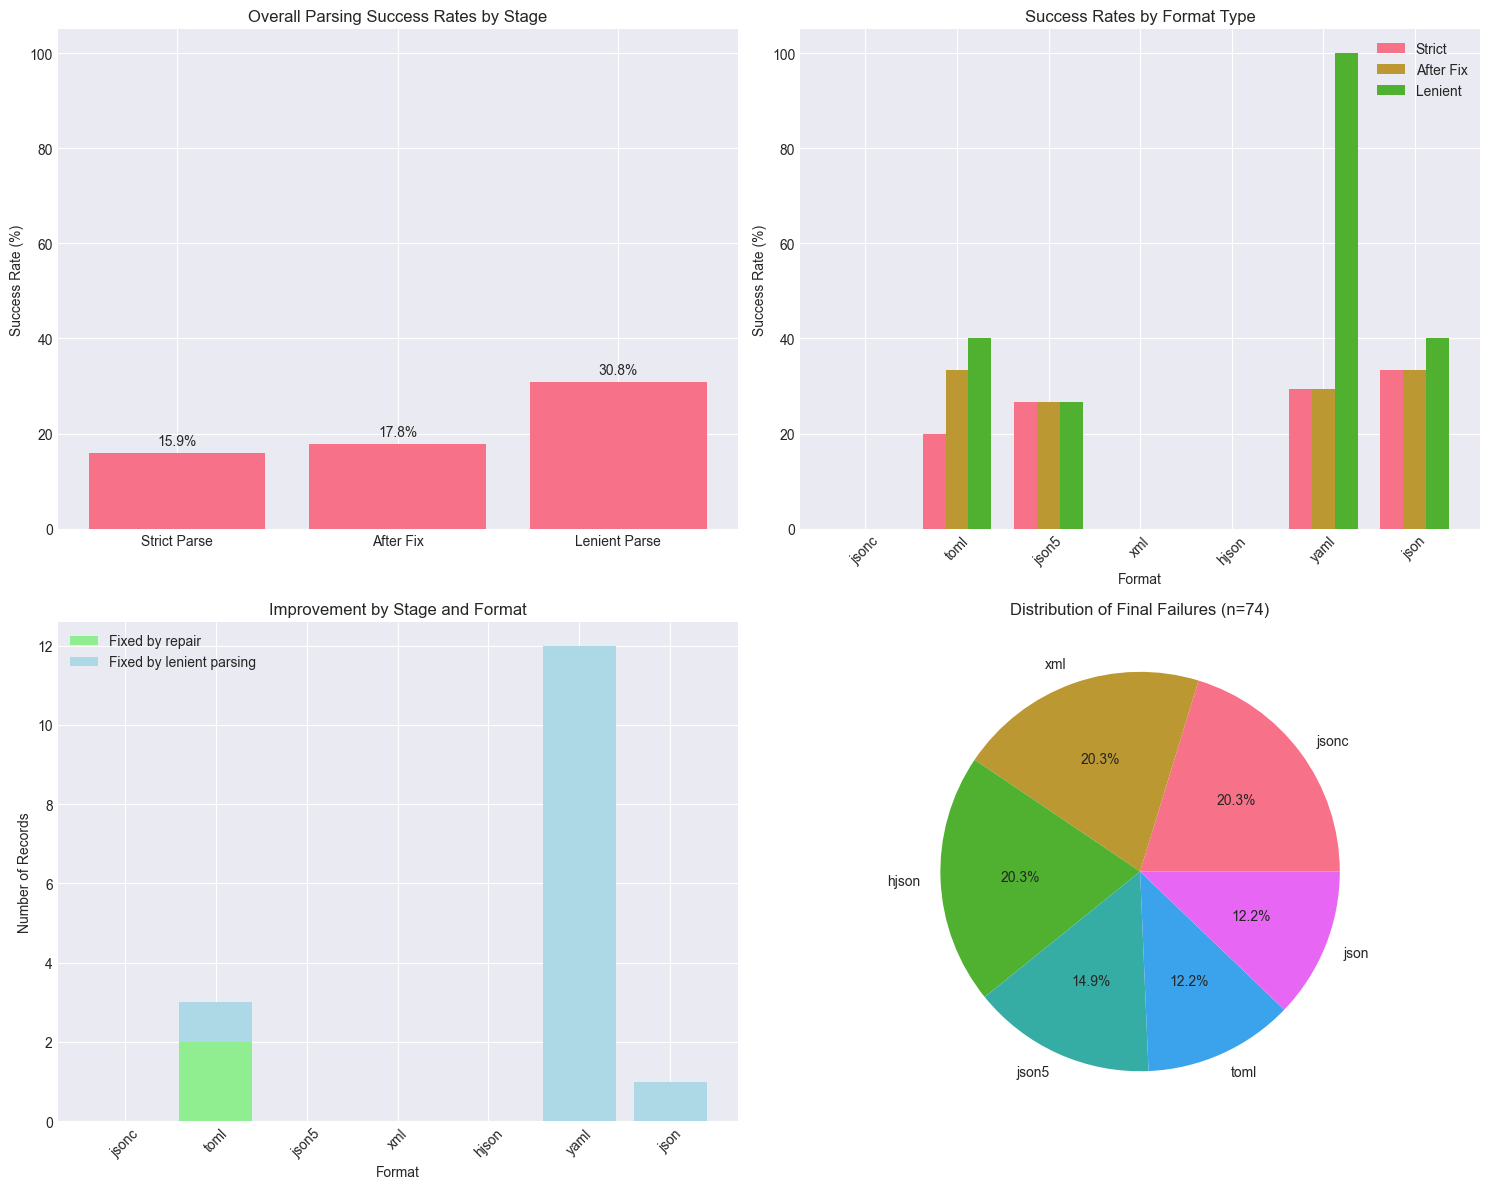

In [5]:

# 处理数据
results = process_dataframe(validator, df_new)

# 生成报告和可视化
report = generate_report(results)
visualize_results(results, report)

In [6]:
results

,id,format,user_input,parse_success_strict,parse_error,fixed_input,parse_success_after_fix,parse_success_lenient
0,67895b7d6400163124042af7,jsonc,"{\r\n // version details\r\n ""version"": ...",False,"Expecting ',' delimiter: line 7 column 6 (char...","{\r\n \n ""version"": ""4.4.8"", \n \r\n ...",False,False
1,659960f32faa4ff4b116de92,toml,"version = 4.4.7\r\n[repository]\r\ntype = ""git...",False,could not convert string to float: '4.4.7' (li...,"version = ""4.4.7\r""\n[repository]\r\ntype = ""g...",True,True
2,5f7f239e9b204e05b6c36538,json5,"{ ""version"": ""4.4.7""\r\n""repository"":{\r\n""aut...",False,"<string>:1 Unexpected """""" at column 3","{ ""version"": ""4.4.7""\r\n""repository"":{\r\n""aut...",False,False
3,67b8636acd5ed420cc098b64,toml,"version = ""4-4-7""\r\n(repository)\r\n(reposito...",False,Found invalid character in key name: ')'. Try ...,"version = ""4-4-7""\r\n(repository)\r\n(reposito...",False,False
4,57ca4b09993b08000192297b,xml,<version>4.4.7</version>\r\n<repository>\r\n ...,False,"junk after document element: line 2, column 0","<?xml version=""1.0"" encoding=""UTF-8""?>\n<versi...",False,False
...,...,...,...,...,...,...,...,...
102,5755c957eb80c4000741a9ce,json5,"{\r\n version: ""4.4.7"",\r\n repository: ...",True,,"{\r\n version: ""4.4.7"",\r\n repository: ...",True,True
103,6693d3ae2bd15cf7a058e6a7,json5,"{\r\n ""version"" 4.4.7\r\n \r\n}\r\n ""repositor...",False,"<string>:2 Unexpected """""" at column 2","{\r\n ""version"" 4.4.7\r\n \r\n}\r\n ""repositor...",False,False
104,60e2bf0aa568b97e8d525872,toml,"version = ""4.4.7""\r\n\r\n[keywords]\r\nkeyword...",True,,"version = ""4.4.7""\r\n\r\n[keywords]\r\nkeyword...",True,True
105,67d24179c5bd87691f1fe036,yaml,version: 4.4.7\r\nrepository:\r\n author:\r...,True,,version: 4.4.7\r\nrepository:\r\n author:\r...,True,True


In [17]:
report['by_format']['xml']

{'count': 15,
 'strict_success': 0,
 'strict_rate': 0.0,
 'after_fix_success': 0,
 'after_fix_rate': 0.0,
 'lenient_success': 0,
 'lenient_rate': 0.0}